In [1]:
import cv2
import matplotlib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from shapely import affinity
from shapely import geometry
from shapely import wkt
from PIL import Image
import tifffile


def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix


def mask_for_polygons(polygons, im_size):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask

    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


def show_mask(m):
    # hack for nice display
    tifffile.imshow(255 * np.stack([m, m, m]));

In [2]:
SELECTED = '6100_2_2' # Use line of training csv
CLASSTYPE = 'ClassType'
IMAGE_ID = 'ImageId'
INPUT = '../input'
POLYGON = 'MultipolygonWKT'
THREE_BAND = '../input/three_band'
TIF = '.tif'
XMAX = 'Xmax'
YMIN = 'Ymin'

train_labels = pd.read_csv('../input/train_wkt_v4.csv', index_col=[IMAGE_ID, CLASSTYPE])

grid = pd.read_csv('../input/grid_sizes.csv', index_col=0)

(<matplotlib.figure.Figure at 0x7fd065f86860>,
 <matplotlib.image.AxesImage at 0x7fd049fcdbe0>)

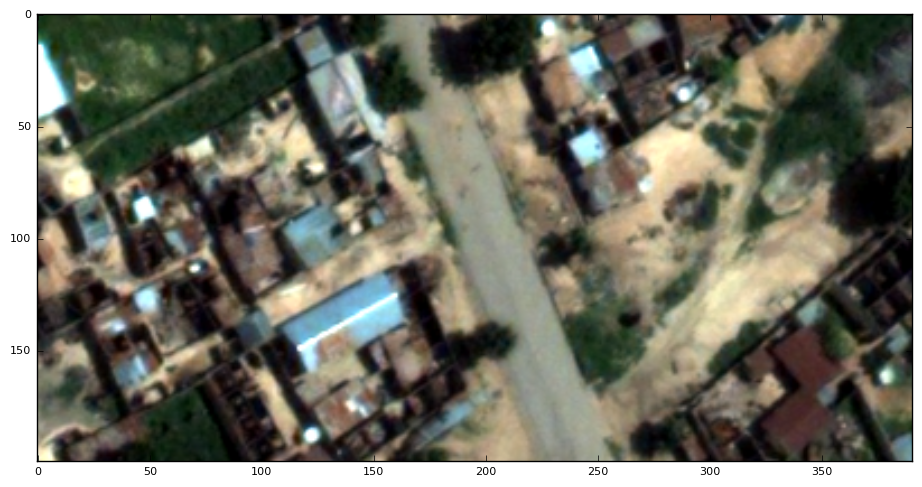

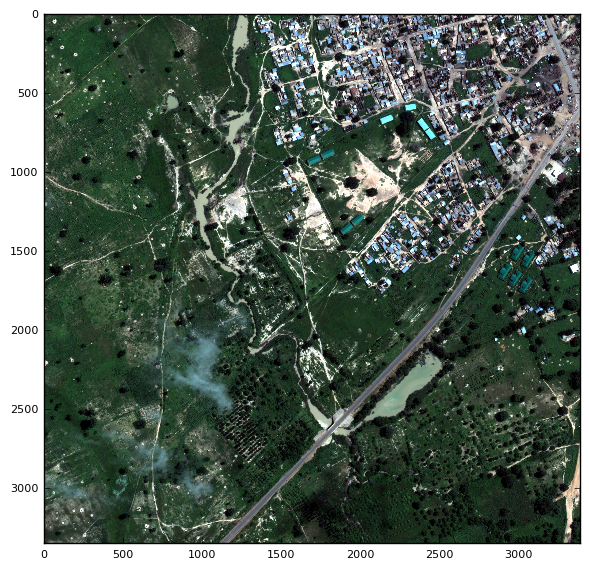

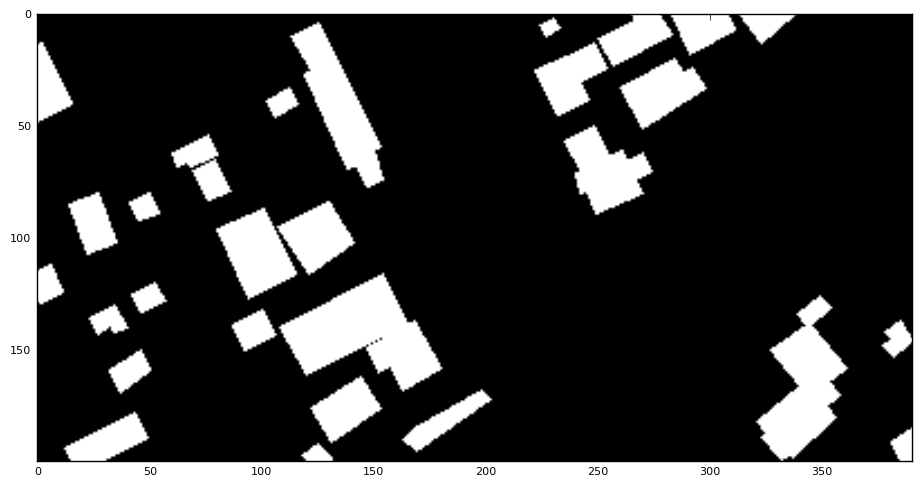

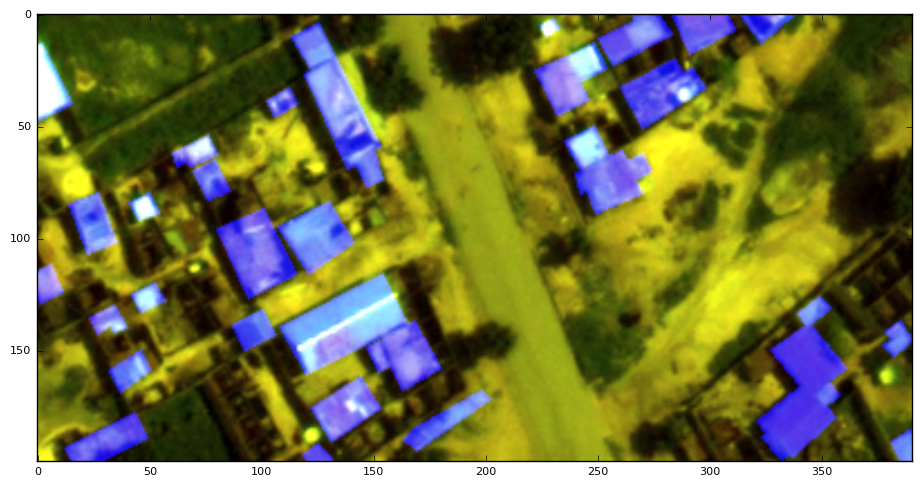

In [3]:
row = train_labels.loc[SELECTED, 1]

image = tifffile.imread(os.path.join(THREE_BAND, SELECTED + TIF)).transpose([1,2,0])

masks = affinity.scale(wkt.loads(row[POLYGON]),
                       xfact=image.shape[1]/grid.loc[SELECTED, XMAX],
                       yfact=image.shape[0]/grid.loc[SELECTED, YMIN],
                       origin=(0, 0, 0))

x0, y0, x1, y1 = masks.geoms[0].exterior.bounds

tifffile.imshow(255 * scale_percentile(image[:200:,3000:]))
tifffile.imshow(255 * scale_percentile(image))
show_mask(mask_for_polygons(masks, image.shape[:2])[:200:,3000:])
aa = np.copy(image)
aa[:,:,2] += mask_for_polygons(masks, image.shape[:2]) * 1000
tifffile.imshow(255 * scale_percentile(aa)[:200:,3000:])